# This is the script used for  classification on Bradykineisa and Parkinson
### Inherited from the original research, reference: https://www.researchgate.net/publication/332174157_Supervised_Classification_of_Bradykinesia_for_Parkinson%27s_Disease_Diagnosis_from_Smartphone_Videos

#### Edited version, only SVM, NB and LR are used in this script.

In [26]:
import numpy as np
import scipy as sp
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, KFold, LeaveOneOut, ParameterGrid, validation_curve, train_test_split, permutation_test_score
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.evaluate import paired_ttest_5x2cv
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

%matplotlib inline

# Read in raw data and combine into one

David was kind enough to do all the signal processing stuff and save the results!

In [3]:
#file = 'PCA_features.xlsx' # Original with 2 components
file = 'PCA_features_extended_all_normalised_20 - Copy - Copy - Copy.xlsx' # FIXED FROM PREVIOUS ERROR IN F1
controls = pd.read_excel(file, sheet_name='PCA_Control', names=['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'vidname'], header=None)
patients = pd.read_excel(file, sheet_name='PCA_Patient', names=['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'vidname'], header=None)
output = pd.read_csv('classes.csv', header=0)
controls["id"] = np.arange(len(controls))
patients["id"] = np.arange(len(controls), len(controls)+len(patients))
output["id"] = np.arange(len(output))
drop_ids = list()
drop_ids.extend(controls.id[[26,27]])
drop_ids.extend(patients.id[[32]])
controls = controls.drop(np.where(controls.id.isin(drop_ids))[0], axis=0)
patients = patients.drop(np.where(patients.id.isin(drop_ids))[0], axis=0)
output = output.drop(np.where(patients.id.isin(drop_ids))[0], axis=0)

In [4]:
data = pd.concat([controls, patients]).join(output, on='id', rsuffix='_out').reset_index(drop=True)
data = data.drop('id_out', axis=1)
myrange = lambda x: np.max(x) - np.min(x)
data["f1_scale"] = (data.feature1 - data.feature1.mean())/myrange(data.feature1)
data["f2_scale"] = (data.feature2 - data.feature2.mean())/myrange(data.feature2)
data.head()

,feature1,feature2,feature3,feature4,feature5,vidname,id,Diagnosis,0 vs 1-4,0-1 vs 2-4,f1_scale,f2_scale
0,0.649419,-0.359161,-0.321332,-0.278546,-0.551973,OC01_L,0,-1,1,-1,0.086806,-0.064719
1,-0.095247,-0.781557,0.365789,-0.302109,-0.067279,OC01_R,1,-1,1,-1,-0.006133,-0.138105
2,-0.136738,-0.709607,0.365789,-0.302109,-0.590771,OC02_L,2,-1,1,-1,-0.011311,-0.125605
3,-2.322429,1.986924,1.589712,2.380408,0.340957,OC02_R,3,-1,1,1,-0.284097,0.342884
4,-2.706076,2.539296,1.788359,2.157057,1.063579,OC03_L,4,-1,-1,-1,-0.331978,0.438852


In [5]:
def person_crossval(X, pid):
    uniquepids = list(set([x[:-2] for x in pid]))
    
    for curpid in uniquepids:
        yield [not x.startswith(curpid) for x in pid], [x.startswith(curpid) for x in pid]
    

Quick plot to check it matches the one in the current plots: it does!

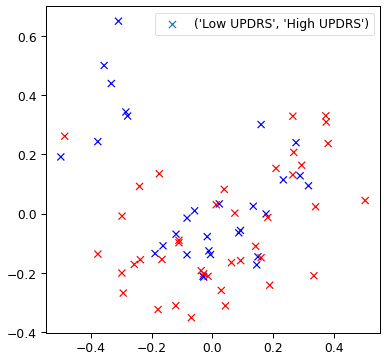

In [6]:
sns.set_context("paper", font_scale=1.4)
plt.figure(figsize=[6,6])
plt.scatter(data.f1_scale, data.f2_scale, c=data.Diagnosis, cmap=plt.cm.bwr, marker='x', s=50, label=('Low UPDRS', 'High UPDRS'))
plt.legend()

# Retrain models from the paper - UPDRS

## SVM

In [100]:
svm = SVC(kernel='rbf', probability=True)
rand_state = 42
K_fold = KFold(n_splits=10, shuffle=True, random_state=rand_state)

grid = {
    'C': np.expand_dims(np.logspace(0, 3, 100), axis=1),
    'gamma': np.expand_dims(np.linspace(0, 5, 100), axis=1),
}

p_grid = ParameterGrid(grid)
svmclf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=K_fold)

svmclf.fit(data[['f1_scale', 'f2_scale']], data["0-1 vs 2-4"])

print(classification_report(data["0-1 vs 2-4"], svmclf.predict(data[['f1_scale', 'f2_scale']])))
print('Accuracy =', accuracy_score(data["0-1 vs 2-4"], svmclf.predict(data[['f1_scale', 'f2_scale']])))
print('AUC =', roc_auc_score(data["0-1 vs 2-4"], svmclf.predict(data[['f1_scale', 'f2_scale']])))

              precision    recall  f1-score   support

          -1       0.72      0.76      0.74        34
           1       0.76      0.72      0.74        36

    accuracy                           0.74        70
   macro avg       0.74      0.74      0.74        70
weighted avg       0.74      0.74      0.74        70

Accuracy = 0.7428571428571429
AUC = 0.7434640522875817


0.6005942857142855 0.05886419763544988
[0.55714286 0.61428571 0.65714286]


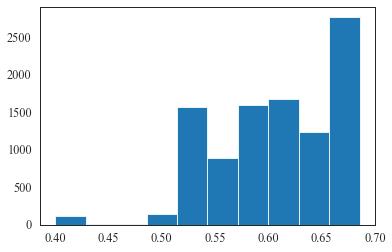

In [101]:
plt.hist(svmclf.cv_results_['mean_test_score'])
print(np.mean(svmclf.cv_results_['mean_test_score']), np.std(svmclf.cv_results_['mean_test_score']))
print(np.percentile(svmclf.cv_results_['mean_test_score'], [25, 50, 75]))

In [92]:
for threshold in np.arange(0.5, 0.65, 0.0002):
    if np.all((svmclf.predict_proba(data[['f1_scale', 'f2_scale']])[:,1]>threshold) == (svmclf.predict(data[['f1_scale', 'f2_scale']]) == 1)):
        break
print('Threshold =', threshold)

Threshold = 0.5117999999999987


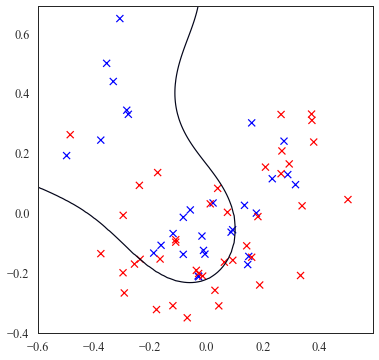

In [93]:
# Plot boundary
xx, yy = np.meshgrid(np.arange(-0.6, 0.6, 0.01), np.arange(-0.4, 0.7, 0.01))
X = np.array([xx.ravel(), yy.ravel()]).T
Z = svmclf.predict_proba(X)[:,1]
Z = Z.reshape(xx.shape)
sns.set_context("paper", font_scale=1.4)
plt.figure(figsize=[6,6])
plt.scatter(data.f1_scale, data.f2_scale, c=data.Diagnosis, cmap=plt.cm.bwr, marker='x', s=50)
plt.contour(xx, yy, Z, [threshold])

In [94]:
svmclf.best_estimator_.get_params()

{'C': 8.697490026177835,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 4.848484848484849,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

## NB

In [18]:
nbclf = GaussianNB()

nbclf.fit(data[['f1_scale', 'f2_scale']], data["0-1 vs 2-4"])

print(classification_report(data["0-1 vs 2-4"], nbclf.predict(data[['f1_scale', 'f2_scale']])))
print('Accuracy =', accuracy_score(data["0-1 vs 2-4"], nbclf.predict(data[['f1_scale', 'f2_scale']])))
print('AUC =', roc_auc_score(data["0-1 vs 2-4"], nbclf.predict(data[['f1_scale', 'f2_scale']])))

              precision    recall  f1-score   support

          -1       0.62      0.47      0.53        34
           1       0.59      0.72      0.65        36

    accuracy                           0.60        70
   macro avg       0.60      0.60      0.59        70
weighted avg       0.60      0.60      0.59        70

Accuracy = 0.6
AUC = 0.5964052287581699


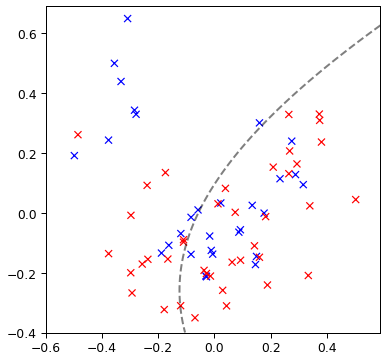

In [19]:
# Plot boundary
xx, yy = np.meshgrid(np.arange(-0.6, 0.6, 0.01), np.arange(-0.4, 0.7, 0.01))
X = np.array([xx.ravel(), yy.ravel()]).T
Z = nbclf.predict_proba(X)[:,1]
Z = Z.reshape(xx.shape)
sns.set_context("paper", font_scale=1.4)
plt.figure(figsize=[6,6])
plt.scatter(data.f1_scale, data.f2_scale, c=data.Diagnosis, cmap=plt.cm.bwr, marker='x', s=50)
plt.contour(xx, yy, Z, [0.5], linestyles='dashed', linewidths=2, colors='k', alpha=0.5)

## Logistic

In [20]:
svml = SVC(kernel='linear', probability=True)
rand_state = 42
K_fold = KFold(n_splits=10, shuffle=True, random_state=rand_state)
lrclf = LogisticRegressionCV(Cs=100, solver='lbfgs', cv=K_fold)

lrclf.fit(data[['f1_scale', 'f2_scale']], data["0-1 vs 2-4"])

print(classification_report(data["0-1 vs 2-4"], lrclf.predict(data[['f1_scale', 'f2_scale']])))
print('Accuracy =', accuracy_score(data["0-1 vs 2-4"], lrclf.predict(data[['f1_scale', 'f2_scale']])))
print('AUC =', roc_auc_score(data["0-1 vs 2-4"], lrclf.predict(data[['f1_scale', 'f2_scale']])))
print(lrclf.C_)

              precision    recall  f1-score   support

          -1       0.67      0.47      0.55        34
           1       0.61      0.78      0.68        36

    accuracy                           0.63        70
   macro avg       0.64      0.62      0.62        70
weighted avg       0.64      0.63      0.62        70

Accuracy = 0.6285714285714286
AUC = 0.6241830065359477
[0.62802914]


In [21]:
acc_scores = np.concatenate(lrclf.scores_[1])

0.5089999999999999 0.1858258456134646
[0.42857143 0.57142857 0.57142857]


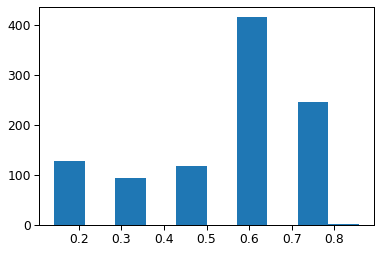

In [22]:
plt.hist(acc_scores)
print(np.mean(acc_scores), np.std(acc_scores))
print(np.percentile(acc_scores, [25, 50, 75]))

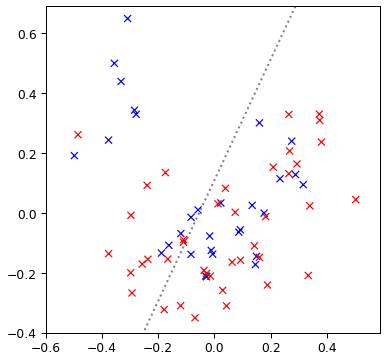

In [23]:
# Plot boundary
xx, yy = np.meshgrid(np.arange(-0.6, 0.6, 0.01), np.arange(-0.4, 0.7, 0.01))
X = np.array([xx.ravel(), yy.ravel()]).T
Z = lrclf.predict_proba(X)[:,1]
Z = Z.reshape(xx.shape)
sns.set_context("paper", font_scale=1.4)
plt.figure(figsize=[6,6])
plt.scatter(data.f1_scale, data.f2_scale, c=data.Diagnosis, cmap=plt.cm.bwr, marker='x', s=50)
plt.contour(xx, yy, Z, [0.5], linestyles='dotted', linewidths=2, colors='k', alpha=0.5)

# Retrain Parkinson models

## SVM

In [27]:
svm = SVC(kernel='rbf', probability=True)
rand_state = 42
K_fold = KFold(n_splits=10, shuffle=True, random_state=rand_state)

grid = {
    'C': np.expand_dims(np.logspace(0, 3, 100), axis=1),
    'gamma': np.expand_dims(np.linspace(0, 5, 100), axis=1),
}

p_grid = ParameterGrid(grid)
svmclf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=K_fold)

svmclf.fit(data[['f1_scale', 'f2_scale']], data.Diagnosis)

print(classification_report(data.Diagnosis, svmclf.predict(data[['f1_scale', 'f2_scale']])))
print('Accuracy =', accuracy_score(data.Diagnosis, svmclf.predict(data[['f1_scale', 'f2_scale']])))
print('AUC =', roc_auc_score(data.Diagnosis, svmclf.predict(data[['f1_scale', 'f2_scale']])))

              precision    recall  f1-score   support

          -1       0.88      0.23      0.37        30
           1       0.63      0.97      0.76        40

    accuracy                           0.66        70
   macro avg       0.75      0.60      0.57        70
weighted avg       0.73      0.66      0.59        70

Accuracy = 0.6571428571428571
AUC = 0.6041666666666666


In [28]:
for threshold in np.arange(0.5, 0.65, 0.0002):
    if np.all((svmclf.predict_proba(data[['f1_scale', 'f2_scale']])[:,1]>threshold) == (svmclf.predict(data[['f1_scale', 'f2_scale']]) == 1)):
        break
print('Threshold =', threshold)

Threshold = 0.6499999999999835


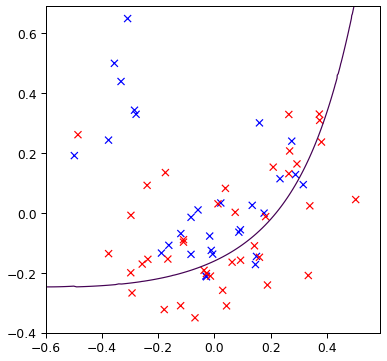

In [29]:
# Plot boundary
xx, yy = np.meshgrid(np.arange(-0.6, 0.6, 0.01), np.arange(-0.4, 0.7, 0.01))
X = np.array([xx.ravel(), yy.ravel()]).T
Z = svmclf.predict_proba(X)[:,1]
Z = Z.reshape(xx.shape)
sns.set_context("paper", font_scale=1.4)
plt.figure(figsize=[6,6])
plt.scatter(data.f1_scale, data.f2_scale, c=data.Diagnosis, cmap=plt.cm.bwr, marker='x', s=50)
plt.contour(xx, yy, Z, [threshold]) # Threshold chosen because pseudoprobabilities incorrectly classified

In [30]:
svmclf.best_estimator_.get_params()

{'C': 1.8738174228603839,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.6060606060606061,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

## NB

In [31]:
nbclf = GaussianNB()

nbclf.fit(data[['f1_scale', 'f2_scale']], data.Diagnosis)

print(classification_report(data.Diagnosis, nbclf.predict(data[['f1_scale', 'f2_scale']])))
print('Accuracy =', accuracy_score(data.Diagnosis, nbclf.predict(data[['f1_scale', 'f2_scale']])))
print('AUC =', roc_auc_score(data.Diagnosis, nbclf.predict(data[['f1_scale', 'f2_scale']])))

              precision    recall  f1-score   support

          -1       0.62      0.27      0.37        30
           1       0.61      0.88      0.72        40

    accuracy                           0.61        70
   macro avg       0.61      0.57      0.55        70
weighted avg       0.61      0.61      0.57        70

Accuracy = 0.6142857142857143
AUC = 0.5708333333333333


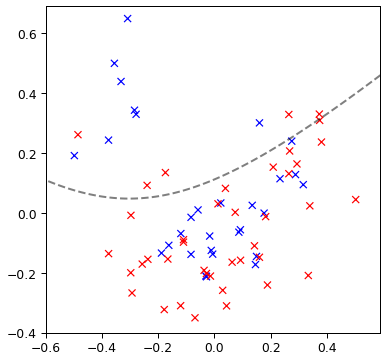

In [32]:
# Plot boundary
xx, yy = np.meshgrid(np.arange(-0.6, 0.6, 0.01), np.arange(-0.4, 0.7, 0.01))
X = np.array([xx.ravel(), yy.ravel()]).T
Z = nbclf.predict_proba(X)[:,1]
Z = Z.reshape(xx.shape)
sns.set_context("paper", font_scale=1.4)
plt.figure(figsize=[6,6])
plt.scatter(data.f1_scale, data.f2_scale, c=data.Diagnosis, cmap=plt.cm.bwr, marker='x', s=50)
plt.contour(xx, yy, Z, [0.5], linestyles='dashed', linewidths=2, colors='k', alpha=0.5)

# LR

In [39]:
myfeatures = ['f1_scale', 'f2_scale', 'f3_scale', 'f4_scale', 'f5_scale']
svm = SVC(kernel='rbf', probability=True)
rand_state = 42
K_fold = KFold(n_splits=10, shuffle=True, random_state=rand_state)

grid = {
    'C': np.expand_dims(np.logspace(0, 3, 100), axis=1),
    'gamma': np.expand_dims(np.linspace(0, 5, 100), axis=1),
}

p_grid = ParameterGrid(grid)
svmclf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=K_fold)

svmclf.fit(data[['f1_scale', 'f2_scale']], data["0-1 vs 2-4"])

print(classification_report(data["0-1 vs 2-4"], svmclf.predict(data[['f1_scale', 'f2_scale']])))
print('Accuracy =', accuracy_score(data["0-1 vs 2-4"], svmclf.predict(data[['f1_scale', 'f2_scale']])))
print('AUC =', roc_auc_score(data["0-1 vs 2-4"], svmclf.predict(data[['f1_scale', 'f2_scale']])))

              precision    recall  f1-score   support

          -1       0.72      0.76      0.74        34
           1       0.76      0.72      0.74        36

    accuracy                           0.74        70
   macro avg       0.74      0.74      0.74        70
weighted avg       0.74      0.74      0.74        70

Accuracy = 0.7428571428571429
AUC = 0.7434640522875817


<ipython-input-40-f83340162de0>:9: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, Z, [0.5], linestyles='dotted', linewidths=2, colors='k', alpha=0.5)


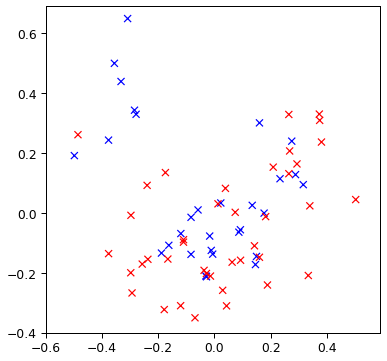

In [40]:
# Plot boundary
xx, yy = np.meshgrid(np.arange(-0.6, 0.6, 0.01), np.arange(-0.4, 0.7, 0.01))
X = np.array([xx.ravel(), yy.ravel()]).T
Z = lrclf.predict_proba(X)[:,1]
Z = Z.reshape(xx.shape)
sns.set_context("paper", font_scale=1.4)
plt.figure(figsize=[6,6])
plt.scatter(data.f1_scale, data.f2_scale, c=data.Diagnosis, cmap=plt.cm.bwr, marker='x', s=50)
plt.contour(xx, yy, Z, [0.5], linestyles='dotted', linewidths=2, colors='k', alpha=0.5)

<ipython-input-41-f83340162de0>:9: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, Z, [0.5], linestyles='dotted', linewidths=2, colors='k', alpha=0.5)


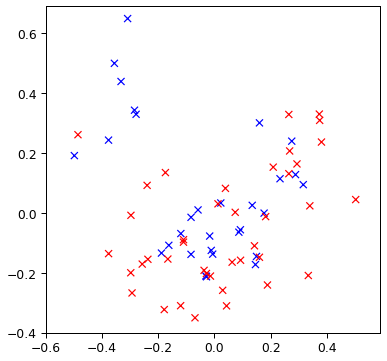

In [41]:
# Plot boundary
xx, yy = np.meshgrid(np.arange(-0.6, 0.6, 0.01), np.arange(-0.4, 0.7, 0.01))
X = np.array([xx.ravel(), yy.ravel()]).T
Z = lrclf.predict_proba(X)[:,1]
Z = Z.reshape(xx.shape)
sns.set_context("paper", font_scale=1.4)
plt.figure(figsize=[6,6])
plt.scatter(data.f1_scale, data.f2_scale, c=data.Diagnosis, cmap=plt.cm.bwr, marker='x', s=50)
plt.contour(xx, yy, Z, [0.5], linestyles='dotted', linewidths=2, colors='k', alpha=0.5)